# Question 1

### Import packages

In [1]:
import biogeme.version as ver
import biogeme.database as db
from biogeme.expressions import Beta
import pandas as pd
import biogeme.models as models
import biogeme.biogeme as bio
import numpy as np

In [2]:
print(ver.getText())

biogeme 3.2.10 [2022-12-09]
Version entirely written in Python
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



### Import data

In [3]:
df = pd.read_csv("model_estimation_data.dat",'\t')
df

<ipython-input-3-32c7139cd031>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv("model_estimation_data.dat",'\t')


,ID,bus_IVT,bus_TA,bus_WT,bus_Cost,BS_TT,BS_Cost,car_TT,car_PT,car_Cost,car_PCost,Choice
0,1,20,10,15,6,50,1.5,45,2,4,5,1
1,2,30,5,10,4,60,3.5,35,2,4,5,3
2,3,20,5,10,4,40,1.5,15,8,4,5,1
3,4,30,5,10,6,50,1.5,45,2,2,5,1
4,5,40,10,10,6,40,1.5,35,2,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,30,5,10,4,50,3.5,15,5,2,3,3
996,997,20,5,10,6,60,1.5,35,2,2,3,1
997,998,50,5,10,6,50,1.5,15,2,4,5,3
998,999,30,10,15,4,40,1.5,45,5,4,3,2


In [4]:
df.describe()

,ID,bus_IVT,bus_TA,bus_WT,bus_Cost,BS_TT,BS_Cost,car_TT,car_PT,car_Cost,car_PCost,Choice
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,35.330000,7.365000,12.550000,4.938000,50.310000,2.506000,29.960000,4.919000,3.100000,4.042000,2.33100
std,288.819436,11.628685,2.497601,2.500751,0.998576,8.103676,1.000482,11.503509,2.464653,0.995485,0.999618,0.86729
min,1.000000,20.000000,5.000000,10.000000,4.000000,40.000000,1.500000,15.000000,2.000000,2.000000,3.000000,1.00000
25%,250.750000,20.000000,5.000000,10.000000,4.000000,40.000000,1.500000,15.000000,2.000000,2.000000,3.000000,1.00000
50%,500.500000,40.000000,5.000000,15.000000,4.000000,50.000000,3.500000,35.000000,5.000000,4.000000,5.000000,3.00000
75%,750.250000,50.000000,10.000000,15.000000,6.000000,60.000000,3.500000,45.000000,8.000000,4.000000,5.000000,3.00000
max,1000.000000,50.000000,10.000000,15.000000,6.000000,60.000000,3.500000,45.000000,8.000000,4.000000,5.000000,3.00000


In [5]:
database = db.Database("model_estimation_data",df)

In [6]:
globals().update(database.variables)

### Model 1

In [7]:
# Parameters to be estimated
ASC_Bus    = Beta('ASC_Bus',0,None,None,0)
ASC_Bike   = Beta('ASC_Bike',0,None,None,1)
ASC_Car    = Beta('ASC_Car',0,None,None,0)

# Note that in above case, the parameter ASC_Bike is not estimated (as specified by the 1 in the fifth argument on 
# the corresponding line), and its value is fixed to 0. Read: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf

# Similarly now, declare parameters for travel time, "Beta_TT" and travel cost, "Beta_TC" below:
Beta_TT    = Beta('Beta_TT', 0, None, None, 0)
Beta_Cost  = Beta('Beta_Cost', 0, None, None, 0)

In [8]:
# Definition of new variables
tot_cost_car = car_Cost + car_PCost

# Similarly now, define new variables for total time for car and total time for bus
tot_time_car = car_TT + car_PT
tot_time_bus = bus_IVT + bus_TA + bus_WT

In [9]:
# Definition of the utility functions (provided for V1-Bus, define yourself for Bike and Car)
V1    =  ASC_Bus + Beta_TT * tot_time_bus  + Beta_Cost * bus_Cost
V2    =  ASC_Bike + Beta_TT * BS_TT + Beta_Cost * BS_Cost
V3    =  ASC_Car + Beta_TT * tot_time_car + Beta_Cost * tot_cost_car

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3}

In [10]:
# Associate the availability conditions with the alternatives
Bus_AV = 1
Bike_AV = 1
Car_AV = 1

av = {1: Bus_AV, 2: Bike_AV, 3: Car_AV}

In [11]:
# Definition of the model. This is the contribution of each observation to the log likelihood function.
logprob = models.loglogit(V, av, Choice)

# Create the Biogeme object
onlyRobust=False
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'Model_1'  

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)

# Command added to avoid any problem with the reported initial loglikelihood. When True, the current iterate is saved after each iteration, in a file named __[modelName].iter
# If such a file exists, the starting values for the estimation are replaced by the values saved in the file.  
biogeme.saveIterations = False 

In [12]:
# Estimate the parameters
results = biogeme.estimate()


# Get the results in a pandas table
pandasResults = results.getEstimatedParameters(onlyRobust=False)

# Use print command with above "pandasResults" as argument to get succint results. 
print(pandasResults)

# However, go to directory folder to access detailed results

              Value   Std err     t-test       p-value  Rob. Std err  \
ASC_Bus    3.877669  0.323599  11.982962  0.000000e+00      0.327207   
ASC_Car    1.013999  0.357000   2.840334  4.506628e-03      0.356375   
Beta_Cost -0.431034  0.070965  -6.073909  1.248338e-09      0.070175   
Beta_TT   -0.344430  0.020693 -16.645110  0.000000e+00      0.019443   

           Rob. t-test  Rob. p-value  
ASC_Bus      11.850809  0.000000e+00  
ASC_Car       2.845311  4.436811e-03  
Beta_Cost    -6.142252  8.135967e-10  
Beta_TT     -17.714589  0.000000e+00  


### Model 2

In [13]:
# Travel mode sensitive parameters to be estimated
ASC_Bus    = Beta('ASC_Bus',0,None,None,0)
ASC_Bike   = Beta('ASC_Bike',0,None,None,1)
ASC_Car    = Beta('ASC_Car',0,None,None,0)

# Bus
Beta_BusTT    = Beta('Beta_BusTT', 0, None, None, 0)
Beta_BusCost  = Beta('Beta_BusCost', 0, None, None, 0)
# Bike
Beta_BikeTT    = Beta('Beta_BikeTT', 0, None, None, 0)
Beta_BikeCost  = Beta('Beta_BikeCost', 0, None, None, 0)
# Car
Beta_CarTT    = Beta('Beta_CarTT', 0, None, None, 0)
Beta_CarCost  = Beta('Beta_CarCost', 0, None, None, 0)

In [14]:
# Definition of new variables
tot_cost_car = car_Cost + car_PCost
tot_time_car = car_TT + car_PT
tot_time_bus = bus_IVT + bus_TA + bus_WT

In [15]:
# Definition of the utility functions
V1    =  ASC_Bus + Beta_BusTT * tot_time_bus  + Beta_BusCost * bus_Cost
V2    =  ASC_Bike + Beta_BikeTT * BS_TT + Beta_BikeCost * BS_Cost
V3    =  ASC_Car + Beta_CarTT * tot_time_car + Beta_CarCost * tot_cost_car

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3}

In [16]:
# Associate the availability conditions with the alternatives
Bus_AV = 1
Bike_AV = 1
Car_AV = 1

av = {1: Bus_AV, 2: Bike_AV, 3: Car_AV}

In [17]:
# Definition of the model. This is the contribution of each observation to the log likelihood function.
logprob = models.loglogit(V, av, Choice)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'Model_2'  

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)

# Command added to avoid any problem with the reported initial loglikelihood. When True, the current iterate is saved after each iteration, in a file named __[modelName].iter
# If such a file exists, the starting values for the estimation are replaced by the values saved in the file.  
biogeme.saveIterations = False 

In [18]:
# Estimate the parameters
results = biogeme.estimate()
# Get the results in a pandas table
pandasResults = results.getEstimatedParameters(onlyRobust=False)

# Use print command with above "pandasResults" as argument to get succint results. 
print(pandasResults)

# However, go to directory folder to access detailed results

                  Value   Std err     t-test       p-value  Rob. Std err  \
ASC_Bus        1.714268  1.622270   1.056710  2.906440e-01      1.511258   
ASC_Car       -0.046624  1.522878  -0.030616  9.755757e-01      1.454006   
Beta_BikeCost -0.364521  0.161903  -2.251470  2.435580e-02      0.151321   
Beta_BikeTT   -0.390736  0.033469 -11.674556  0.000000e+00      0.030240   
Beta_BusCost  -0.047771  0.145061  -0.329317  7.419160e-01      0.151529   
Beta_BusTT    -0.379726  0.026423 -14.371144  0.000000e+00      0.024837   
Beta_CarCost  -0.608615  0.101118  -6.018826  1.756869e-09      0.108854   
Beta_CarTT    -0.334005  0.021809 -15.314960  0.000000e+00      0.021675   

               Rob. t-test  Rob. p-value  
ASC_Bus           1.134332  2.566553e-01  
ASC_Car          -0.032066  9.744192e-01  
Beta_BikeCost    -2.408922  1.599971e-02  
Beta_BikeTT     -12.920965  0.000000e+00  
Beta_BusCost     -0.315261  7.525635e-01  
Beta_BusTT      -15.288662  0.000000e+00  
Beta_CarCost  

### Model 3

In [19]:
# Travel mode sensitive parameters to be estimated
# Bus
ASC_bus = Beta('ASC_bus', 0, None, None, 0)
Beta_IVT = Beta('Beta_IVT', 0, None, None, 0)
Beta_TA = Beta('Beta_TA', 0, None, None, 0)
Beta_WT = Beta('Beta_WT', 0, None, None, 0)
Beta_BusCost = Beta('Beta_BusCost', 0, None, None, 0)
# Bike
ASC_bike = Beta('ASC_bike', 0, None, None, 1)
Beta_BikeTT = Beta('Beta_BikeTT', 0, None, None, 0)
Beta_BikeCost = Beta('Beta_BikeCost', 0, None, None, 0)
# Car
ASC_car = Beta('ASC_car', 0, None, None, 0)
Beta_CarTT = Beta('Beta_CarTT', 0, None, None, 0)
Beta_PT = Beta('Beta_PT', 0, None, None, 0)
Beta_CarCost = Beta('Beta_CarCost', 0, None, None, 0)
Beta_PCost = Beta('Beta_PCost', 0, None, None, 0)

In [20]:
V1 = ASC_bus + \
     Beta_IVT * bus_IVT + \
     Beta_TA * bus_TA + \
     Beta_WT * bus_WT + \
     Beta_BusCost * bus_Cost
V2 = ASC_bike + \
     Beta_BikeTT * BS_TT + \
     Beta_BikeCost * BS_Cost
V3 = ASC_car + \
     Beta_CarTT * car_TT + \
     Beta_PT * car_PT + \
     Beta_CarCost * car_Cost + \
     Beta_PCost * car_PCost

In [21]:
V = {1: V1,
     2: V2,
     3: V3}

In [22]:
av = {1: 1,
      2: 1,
      3: 1}

In [23]:
logprob = models.loglogit(V, av, Choice)

In [24]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'Model_3'
biogeme.calculateNullLoglikelihood(av)
biogeme.saveIterations = False 

In [25]:
results = biogeme.estimate()
pandasRESULTS = results.getEstimatedParameters(onlyRobust=False)
pandasRESULTS

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_bus,-2.721375,1.948336,-1.396769,1.624830e-01,1.807699,-1.505436,1.322121e-01
ASC_car,-0.041921,1.662275,-0.025219,9.798803e-01,1.648369,-0.025432,9.797106e-01
Beta_BikeCost,-0.482563,0.182630,-2.642304,8.234413e-03,0.171955,-2.806331,5.010917e-03
Beta_BikeTT,-0.460691,0.040059,-11.500353,0.000000e+00,0.033477,-13.761376,0.000000e+00
Beta_BusCost,-0.162786,0.159423,-1.021099,3.072078e-01,0.159804,-1.018662,3.083634e-01
Beta_CarCost,-0.257370,0.142748,-1.802964,7.139392e-02,0.153938,-1.671908,9.454243e-02
Beta_CarTT,-0.380804,0.026577,-14.328348,0.000000e+00,0.025747,-14.790001,0.000000e+00
Beta_IVT,-0.478033,0.035210,-13.576558,0.000000e+00,0.031949,-14.962343,0.000000e+00
Beta_PCost,-1.042329,0.155856,-6.687775,2.265899e-11,0.167897,-6.208127,5.361969e-10
Beta_PT,-0.546035,0.069368,-7.871610,3.552714e-15,0.064012,-8.530201,0.000000e+00


### Task 1.4

##### Input parameters

In [26]:
ASC_bus = pandasRESULTS.loc['ASC_bus','Value']
ASC_car = pandasRESULTS.loc['ASC_car','Value']
Beta_IVT = pandasRESULTS.loc['Beta_IVT','Value']
Beta_TA = pandasRESULTS.loc['Beta_TA','Value']
Beta_WT = pandasRESULTS.loc['Beta_WT','Value']
Beta_BusCost = pandasRESULTS.loc['Beta_BusCost','Value']
Beta_BikeTT = pandasRESULTS.loc['Beta_BikeTT','Value']
Beta_BikeCost = pandasRESULTS.loc['Beta_BikeCost','Value']
Beta_CarTT = pandasRESULTS.loc['Beta_CarTT','Value']
Beta_PT = pandasRESULTS.loc['Beta_PT','Value']
Beta_CarCost = pandasRESULTS.loc['Beta_CarCost','Value']
Beta_PCost = pandasRESULTS.loc['Beta_PCost','Value']

In [27]:
df

,ID,bus_IVT,bus_TA,bus_WT,bus_Cost,BS_TT,BS_Cost,car_TT,car_PT,car_Cost,car_PCost,Choice
0,1,20,10,15,6,50,1.5,45,2,4,5,1
1,2,30,5,10,4,60,3.5,35,2,4,5,3
2,3,20,5,10,4,40,1.5,15,8,4,5,1
3,4,30,5,10,6,50,1.5,45,2,2,5,1
4,5,40,10,10,6,40,1.5,35,2,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,30,5,10,4,50,3.5,15,5,2,3,3
996,997,20,5,10,6,60,1.5,35,2,2,3,1
997,998,50,5,10,6,50,1.5,15,2,4,5,3
998,999,30,10,15,4,40,1.5,45,5,4,3,2


##### Actual Market share

In [28]:
actchoice = df[['Choice']].value_counts().sort_index().reset_index()
AMS = []
AMS.append(actchoice.iloc[0,1]/1000)
AMS.append(actchoice.iloc[1,1]/1000)
AMS.append(actchoice.iloc[2,1]/1000)
print('Actual market share of bus = ', AMS[0])
print('Actual market share of bike sharing = ', AMS[1])
print('Actual market share of car = ', AMS[2])
print('Sum of market share = ', np.sum(AMS))

Actual market share of bus =  0.265
Actual market share of bike sharing =  0.139
Actual market share of car =  0.596
Sum of market share =  1.0


##### Sample enumeration + Average individual approach

In [29]:
df['V_bus'] = ASC_bus + Beta_IVT * df['bus_IVT'] + Beta_TA * df['bus_TA'] + Beta_WT * df['bus_WT'] + \
              Beta_BusCost * df['bus_Cost']
df['V_bike'] = Beta_BikeTT * df['BS_TT'] + Beta_BikeCost * df['BS_Cost']
df['V_car'] = ASC_car + Beta_CarTT * df['car_TT'] + Beta_PT * df['car_PT'] + Beta_CarCost * df['car_Cost'] + \
              Beta_PCost * df['car_PCost']
df['P_bus'] = np.exp(df['V_bus'])/(np.exp(df['V_bus'])+np.exp(df['V_bike'])+np.exp(df['V_car']))
df['P_bike'] = np.exp(df['V_bike'])/(np.exp(df['V_bus'])+np.exp(df['V_bike'])+np.exp(df['V_car']))
df['P_car'] = np.exp(df['V_car'])/(np.exp(df['V_bus'])+np.exp(df['V_bike'])+np.exp(df['V_car']))
df

,ID,bus_IVT,bus_TA,bus_WT,bus_Cost,BS_TT,BS_Cost,car_TT,car_PT,car_Cost,car_PCost,Choice,V_bus,V_bike,V_car,P_bus,P_bike,P_car
0,1,20,10,15,6,50,1.5,45,2,4,5,1,-16.762789,-23.758392,-24.511311,9.986545e-01,0.000915,0.000431
1,2,30,5,10,4,60,3.5,35,2,4,5,3,-19.990542,-29.330428,-20.703267,6.709634e-01,0.000059,0.328978
2,3,20,5,10,4,40,1.5,15,8,4,5,1,-15.210213,-19.151483,-16.363389,7.490322e-01,0.014549,0.236419
3,4,30,5,10,6,50,1.5,45,2,2,5,1,-20.316115,-23.758392,-23.996571,9.458919e-01,0.030261,0.023847
4,5,40,10,10,6,40,1.5,35,2,2,5,2,-25.273417,-19.151483,-20.188527,1.617318e-03,0.737085,0.261297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,30,5,10,4,50,3.5,15,5,2,3,3,-19.990542,-24.723519,-12.125887,3.839330e-04,0.000003,0.999613
996,997,20,5,10,6,60,1.5,35,2,2,3,1,-15.535785,-28.365302,-18.103870,9.287768e-01,0.000002,0.071221
997,998,50,5,10,6,50,1.5,15,2,4,5,3,-29.876774,-23.758392,-13.087179,5.109304e-08,0.000023,0.999977
998,999,30,10,15,4,40,1.5,45,5,4,3,2,-21.217546,-19.151483,-24.064758,1.117107e-01,0.881809,0.006480


In [30]:
MS = []
MS.append(np.sum(df['P_bus'])/1000)
MS.append(np.sum(df['P_bike'])/1000)
MS.append(np.sum(df['P_car'])/1000)
print('Market share of bus = ', MS[0])
print('Market share of bike sharing = ', MS[1])
print('Market share of car = ', MS[2])
print('Sum of market share = ', np.sum(MS))

Market share of bus =  0.265001688344822
Market share of bike sharing =  0.1390004481497579
Market share of car =  0.5959978635054202
Sum of market share =  1.0


In [31]:
avind = df.iloc[:,1:11].describe().iloc[[1]]

avind['V_bus'] = ASC_bus + Beta_IVT * avind['bus_IVT'] + Beta_TA * avind['bus_TA'] + Beta_WT * avind['bus_WT'] + \
              Beta_BusCost * avind['bus_Cost']
avind['V_bike'] = Beta_BikeTT * avind['BS_TT'] + Beta_BikeCost * avind['BS_Cost']
avind['V_car'] = ASC_car + Beta_CarTT * avind['car_TT'] + Beta_PT * avind['car_PT'] + Beta_CarCost * avind['car_Cost'] + \
              Beta_PCost * avind['car_PCost']
avind['P_bus'] = np.exp(avind['V_bus'])/(np.exp(avind['V_bus'])+np.exp(avind['V_bike'])+np.exp(avind['V_car']))
avind['P_bike'] = np.exp(avind['V_bike'])/(np.exp(avind['V_bus'])+np.exp(avind['V_bike'])+np.exp(avind['V_car']))
avind['P_car'] = np.exp(avind['V_car'])/(np.exp(avind['V_bus'])+np.exp(avind['V_bike'])+np.exp(avind['V_car']))

print('Average individual market share of bus = ', avind['P_bus'].iloc[0])
print('Average individual market share of bike sharing = ', avind['P_bike'].iloc[0])
print('Average individual market share of car = ', avind['P_car'].iloc[0])
print('Sum of market share = ', np.sum(avind.iloc[:,13:].transpose()['mean']))

Average individual market share of bus =  0.015247697720131867
Average individual market share of bike sharing =  0.0051972976794782445
Average individual market share of car =  0.9795550046003898
Sum of market share =  0.9999999999999999


# Question 2

##### 4 buses per hour

In [32]:
# Input variables of baseline scenario
base = {
'itb' : 25,
'atb' : 5,
'wtb' : 7.5,
'cb' : 5,
'tc' : 25, 
'ptc' : 2, 
'cc' : 3, 
'pcc' : 5, 
'tbs' : 35, 
'cbs' : 2.5 }

In [33]:
dfbase = pd.DataFrame(base,index=['4bph'])
dfbase

,itb,atb,wtb,cb,tc,ptc,cc,pcc,tbs,cbs
4bph,25,5,7.5,5,25,2,3,5,35,2.5


In [34]:
CMS = []
CMS = pd.DataFrame(CMS)
CMS['V_bus'] = ASC_bus + Beta_IVT * dfbase['itb'] + Beta_TA * dfbase['atb'] + Beta_WT * dfbase['wtb'] + \
              Beta_BusCost * dfbase['cb']
CMS['V_bike'] = Beta_BikeTT * dfbase['tbs'] + Beta_BikeCost * dfbase['cbs']
CMS['V_car'] = ASC_car + Beta_CarTT * dfbase['tc'] + Beta_PT * dfbase['ptc'] + Beta_CarCost * dfbase['cc'] + \
              Beta_PCost * dfbase['pcc']
CMS['P_bus'] = np.exp(CMS['V_bus'])/(np.exp(CMS['V_bus'])+np.exp(CMS['V_bike'])+np.exp(CMS['V_car']))
CMS['P_bike'] = np.exp(CMS['V_bike'])/(np.exp(CMS['V_bus'])+np.exp(CMS['V_bike'])+np.exp(CMS['V_car']))
CMS['P_car'] = np.exp(CMS['V_car'])/(np.exp(CMS['V_bus'])+np.exp(CMS['V_bike'])+np.exp(CMS['V_car']))
CMS

,V_bus,V_bike,V_car,P_bus,P_bike,P_car
4bph,-17.238149,-17.330591,-16.637853,0.267784,0.244139,0.488078


##### 6 buses per hour

In [35]:
base2 = {
'itb' : 25,
'atb' : 5,
'wtb' : 5,
'cb' : 5,
'tc' : 25, 
'ptc' : 2, 
'cc' : 3, 
'pcc' : 5, 
'tbs' : 35, 
'cbs' : 2.5 }

In [36]:
dfbase = dfbase.append(pd.DataFrame(base2,index=['6bph']))

<ipython-input-36-3fee1e9f9b50>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfbase = dfbase.append(pd.DataFrame(base2,index=['6bph']))


In [37]:
CMS = []
CMS = pd.DataFrame(CMS)
CMS['V_bus'] = ASC_bus + Beta_IVT * dfbase['itb'] + Beta_TA * dfbase['atb'] + Beta_WT * dfbase['wtb'] + \
              Beta_BusCost * dfbase['cb']
CMS['V_bike'] = Beta_BikeTT * dfbase['tbs'] + Beta_BikeCost * dfbase['cbs']
CMS['V_car'] = ASC_car + Beta_CarTT * dfbase['tc'] + Beta_PT * dfbase['ptc'] + Beta_CarCost * dfbase['cc'] + \
              Beta_PCost * dfbase['pcc']
CMS['P_bus'] = np.exp(CMS['V_bus'])/(np.exp(CMS['V_bus'])+np.exp(CMS['V_bike'])+np.exp(CMS['V_car']))
CMS['P_bike'] = np.exp(CMS['V_bike'])/(np.exp(CMS['V_bus'])+np.exp(CMS['V_bike'])+np.exp(CMS['V_car']))
CMS['P_car'] = np.exp(CMS['V_car'])/(np.exp(CMS['V_bus'])+np.exp(CMS['V_bike'])+np.exp(CMS['V_car']))
CMS

,V_bus,V_bike,V_car,P_bus,P_bike,P_car
4bph,-17.238149,-17.330591,-16.637853,0.267784,0.244139,0.488078
6bph,-16.713133,-17.330591,-16.637853,0.382044,0.206042,0.411914


##### Integer values £0 to £10

In [38]:
cbv = list(range(0, 11))

In [39]:
dfcbv = []
dfcbv = pd.DataFrame(dfcbv)
for i in cbv:
    basecbv = {
    'itb' : [25],
    'atb' : [5],
    'wtb' :[5],
    'cb' : [i],
    'tc' : [25], 
    'ptc' : [2], 
    'cc' : [3], 
    'pcc' : [5], 
    'tbs' : [35], 
    'cbs' :[2.5] }
    dfcbv = dfcbv.append(pd.DataFrame(basecbv,index=[i]))

<ipython-input-39-89ded6f9b08a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv = dfcbv.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-39-89ded6f9b08a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv = dfcbv.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-39-89ded6f9b08a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv = dfcbv.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-39-89ded6f9b08a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv = dfcbv.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-39-89ded6f9b08a>:15: FutureWarning: The frame.append method is deprecated and will be

In [40]:
VMS = []
VMS = pd.DataFrame(VMS)
VMS['V_bus'] = ASC_bus + Beta_IVT * dfcbv['itb'] + Beta_TA * dfcbv['atb'] + Beta_WT * dfcbv['wtb'] + \
              Beta_BusCost * dfcbv['cb']
VMS['V_bike'] = Beta_BikeTT * dfcbv['tbs'] + Beta_BikeCost * dfcbv['cbs']
VMS['V_car'] = ASC_car + Beta_CarTT * dfcbv['tc'] + Beta_PT * dfcbv['ptc'] + Beta_CarCost * dfcbv['cc'] + \
              Beta_PCost * dfcbv['pcc']
VMS['P_bus'] = np.exp(VMS['V_bus'])/(np.exp(VMS['V_bus'])+np.exp(VMS['V_bike'])+np.exp(VMS['V_car']))
VMS['P_bike'] = np.exp(VMS['V_bike'])/(np.exp(VMS['V_bus'])+np.exp(VMS['V_bike'])+np.exp(VMS['V_car']))
VMS['P_car'] = np.exp(VMS['V_car'])/(np.exp(VMS['V_bus'])+np.exp(VMS['V_bike'])+np.exp(VMS['V_car']))
VMS

,V_bus,V_bike,V_car,P_bus,P_bike,P_car
0,-15.899202,-17.330591,-16.637853,0.582501,0.139204,0.278295
1,-16.061989,-17.330591,-16.637853,0.542463,0.152554,0.304983
2,-16.224775,-17.330591,-16.637853,0.501869,0.166089,0.332042
3,-16.387561,-17.330591,-16.637853,0.461251,0.179632,0.359117
4,-16.550347,-17.330591,-16.637853,0.421140,0.193006,0.385854
5,-16.713133,-17.330591,-16.637853,0.382044,0.206042,0.411914
6,-16.875920,-17.330591,-16.637853,0.344418,0.218587,0.436995
7,-17.038706,-17.330591,-16.637853,0.308647,0.230514,0.460839
8,-17.201492,-17.330591,-16.637853,0.275032,0.241722,0.483246
9,-17.364278,-17.330591,-16.637853,0.243787,0.252140,0.504073


##### Plot relationship

In [41]:
import matplotlib.pyplot as plt

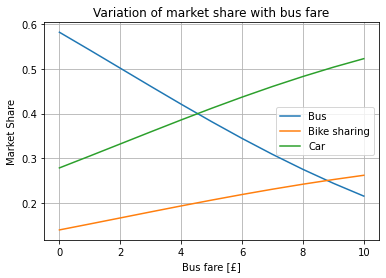

In [42]:
plt.plot(cbv,VMS['P_bus'],label = 'Bus')
plt.plot(cbv,VMS['P_bike'],label = 'Bike sharing')
plt.plot(cbv,VMS['P_car'],label = 'Car')

plt.legend()
plt.title('Variation of market share with bus fare')
plt.xlabel('Bus fare [£]')
plt.ylabel('Market Share')
plt.axis('tight')
plt.grid()

# Question 3

### Task 3.1

In [43]:
cbv = list(range(0, 11))
dfcbv_four = []
dfcbv_four = pd.DataFrame(dfcbv_four)
for i in cbv:
    basecbv = {
    'itb' : [25],
    'atb' : [5],
    'wtb' :[7.5],
    'cb' : [i],
    'tc' : [25], 
    'ptc' : [2], 
    'cc' : [3], 
    'pcc' : [5], 
    'tbs' : [35], 
    'cbs' :[2.5] }
    dfcbv_four = dfcbv_four.append(pd.DataFrame(basecbv,index=[i]))

<ipython-input-43-e224176d33a0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_four = dfcbv_four.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-43-e224176d33a0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_four = dfcbv_four.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-43-e224176d33a0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_four = dfcbv_four.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-43-e224176d33a0>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_four = dfcbv_four.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-43-e224176d33a0>:16: FutureWarning: The frame

In [44]:
dfcbv_four['V_bus'] = ASC_bus + Beta_IVT * dfcbv_four['itb'] + Beta_TA * dfcbv_four['atb'] + Beta_WT * dfcbv_four['wtb'] + \
              Beta_BusCost * dfcbv_four['cb']
dfcbv_four['V_bike'] = Beta_BikeTT * dfcbv_four['tbs'] + Beta_BikeCost * dfcbv_four['cbs']
dfcbv_four['V_car'] = ASC_car + Beta_CarTT * dfcbv_four['tc'] + Beta_PT * dfcbv_four['ptc'] + Beta_CarCost * dfcbv_four['cc'] + \
              Beta_PCost * dfcbv_four['pcc']

In [45]:
dfcbv_four['Ecs'] = 1 / -Beta_BusCost * np.log(np.exp(dfcbv_four['V_bus']) +
                        np.exp(dfcbv_four['V_bike']) + np.exp(dfcbv_four['V_car']))

In [46]:
CMS['Ecs'] = 1 / -Beta_BusCost * np.log(np.exp(CMS['V_bus']) +
                        np.exp(CMS['V_bike']) + np.exp(CMS['V_car']))

In [47]:
dfcbv_four['dEcs'] = ( dfcbv_four['Ecs'] - CMS['Ecs'][0] ) * 1000

In [48]:
cbv = list(range(0, 11))
dfcbv_six = []
dfcbv_six = pd.DataFrame(dfcbv_six)
for i in cbv:
    basecbv = {
    'itb' : [25],
    'atb' : [5],
    'wtb' :[5],
    'cb' : [i],
    'tc' : [25], 
    'ptc' : [2], 
    'cc' : [3], 
    'pcc' : [5], 
    'tbs' : [35], 
    'cbs' :[2.5] }
    dfcbv_six = dfcbv_six.append(pd.DataFrame(basecbv,index=[i]))

<ipython-input-48-1709b20eb170>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_six = dfcbv_six.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-48-1709b20eb170>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_six = dfcbv_six.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-48-1709b20eb170>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_six = dfcbv_six.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-48-1709b20eb170>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcbv_six = dfcbv_six.append(pd.DataFrame(basecbv,index=[i]))
<ipython-input-48-1709b20eb170>:16: FutureWarning: The frame.append 

In [49]:
dfcbv_six['V_bus'] = ASC_bus + Beta_IVT * dfcbv_six['itb'] + Beta_TA * dfcbv_six['atb'] + Beta_WT * dfcbv_six['wtb'] + \
              Beta_BusCost * dfcbv_six['cb']
dfcbv_six['V_bike'] = Beta_BikeTT * dfcbv_six['tbs'] + Beta_BikeCost * dfcbv_six['cbs']
dfcbv_six['V_car'] = ASC_car + Beta_CarTT * dfcbv_six['tc'] + Beta_PT * dfcbv_six['ptc'] + Beta_CarCost * dfcbv_six['cc'] + \
              Beta_PCost * dfcbv_six['pcc']
dfcbv_six['Ecs'] = 1 / -Beta_BusCost * np.log(np.exp(dfcbv_six['V_bus']) +
                        np.exp(dfcbv_six['V_bike']) + np.exp(dfcbv_six['V_car']))
dfcbv_six['dEcs'] = ( dfcbv_six['Ecs'] - CMS['Ecs'][0] ) * 1000
dfcbv_six

,itb,atb,wtb,cb,tc,ptc,cc,pcc,tbs,cbs,V_bus,V_bike,V_car,Ecs,dEcs
0,25,5,5,0,25,2,3,5,35,2.5,-15.899202,-17.330591,-16.637853,-94.349388,3451.117338
1,25,5,5,1,25,2,3,5,35,2.5,-16.061989,-17.330591,-16.637853,-94.911939,2888.567214
2,25,5,5,2,25,2,3,5,35,2.5,-16.224775,-17.330591,-16.637853,-95.434129,2366.376545
3,25,5,5,3,25,2,3,5,35,2.5,-16.387561,-17.330591,-16.637853,-95.915669,1884.837004
4,25,5,5,4,25,2,3,5,35,2.5,-16.550347,-17.330591,-16.637853,-96.356800,1443.705801
5,25,5,5,5,25,2,3,5,35,2.5,-16.713133,-17.330591,-16.637853,-96.758287,1042.218311
6,25,5,5,6,25,2,3,5,35,2.5,-16.875920,-17.330591,-16.637853,-97.121379,679.127121
7,25,5,5,7,25,2,3,5,35,2.5,-17.038706,-17.330591,-16.637853,-97.447742,352.763341
8,25,5,5,8,25,2,3,5,35,2.5,-17.201492,-17.330591,-16.637853,-97.739392,61.114015
9,25,5,5,9,25,2,3,5,35,2.5,-17.364278,-17.330591,-16.637853,-97.998597,-198.091557


### Task 3.2

##### Iteration of  £5 fare cost and 4 buses per hour

In [50]:
dfcbv_four['P_bus'] = np.exp(dfcbv_four['V_bus'])/(np.exp(dfcbv_four['V_bus'])+np.exp(dfcbv_four['V_bike'])+np.exp(dfcbv_four['V_car']))
dfcbv_four['P_bike'] = np.exp(dfcbv_four['V_bike'])/(np.exp(dfcbv_four['V_bus'])+np.exp(dfcbv_four['V_bike'])+np.exp(dfcbv_four['V_car']))
dfcbv_four['P_car'] = np.exp(dfcbv_four['V_car'])/(np.exp(dfcbv_four['V_bus'])+np.exp(dfcbv_four['V_bike'])+np.exp(dfcbv_four['V_car']))
dfcbv_four

,itb,atb,wtb,cb,tc,ptc,cc,pcc,tbs,cbs,V_bus,V_bike,V_car,Ecs,dEcs,P_bus,P_bike,P_car
0,25,5,7.5,0,25,2,3,5,35,2.5,-16.424218,-17.330591,-16.637853,-96.018510,1781.996014,0.452155,0.182665,0.365180
1,25,5,7.5,1,25,2,3,5,35,2.5,-16.587004,-17.330591,-16.637853,-96.450629,1349.876578,0.412231,0.195977,0.391793
2,25,5,7.5,2,25,2,3,5,35,2.5,-16.749790,-17.330591,-16.637853,-96.843346,957.160208,0.373428,0.208914,0.417658
3,25,5,7.5,3,25,2,3,5,35,2.5,-16.912576,-17.330591,-16.637853,-97.198007,602.498548,0.336189,0.221331,0.442480
4,25,5,7.5,4,25,2,3,5,35,2.5,-17.075362,-17.330591,-16.637853,-97.516368,284.138044,0.300880,0.233104,0.466016
5,25,5,7.5,5,25,2,3,5,35,2.5,-17.238149,-17.330591,-16.637853,-97.800506,0.000000,0.267784,0.244139,0.488078
6,25,5,7.5,6,25,2,3,5,35,2.5,-17.400935,-17.330591,-16.637853,-98.052738,-252.232105,0.237093,0.254372,0.508535
7,25,5,7.5,7,25,2,3,5,35,2.5,-17.563721,-17.330591,-16.637853,-98.275531,-475.025022,0.208916,0.263766,0.527317
8,25,5,7.5,8,25,2,3,5,35,2.5,-17.726507,-17.330591,-16.637853,-98.471420,-670.913744,0.183284,0.272313,0.544403
9,25,5,7.5,9,25,2,3,5,35,2.5,-17.889293,-17.330591,-16.637853,-98.642935,-842.429412,0.160160,0.280023,0.559817


In [51]:
tolerance = 1e-6
flow_car = dfcbv_four.iloc[5]['P_car'] * 1000
V_car = 0
V_bus = dfcbv_four.iloc[5]['V_bus']
V_bike = dfcbv_four.iloc[5]['V_bike']
tc = dfcbv_four.iloc[5]['tc']
ptc = dfcbv_four.iloc[5]['ptc']
cc = dfcbv_four.iloc[5]['cc']
pcc = dfcbv_four.iloc[5]['pcc']
iters = float(0)
runs = 1e6
tf = 1/3
K = 200
lamb = 0.1
diff = float("inf")
tciter = []
flow_cariter = []
while diff > tolerance and iters < runs:
    tcnew = tf * (1 + 0.15 * (flow_car/K) ** 4) * 60 
    tciter.append(tcnew)
    V_car = ASC_car + Beta_CarTT * tcnew + Beta_PT * ptc + Beta_CarCost * cc + \
              Beta_PCost * pcc
    flow_car_n = np.exp(V_car)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
    flow_car_it = lamb * flow_car_n + (1 - lamb) * flow_car
    diff = abs((flow_car_it-flow_car_n)/flow_car_n)
    flow_cariter.append(flow_car_it)
    flow_car = flow_car_it
    iters += 1
dnEcs = 1 / -Beta_BusCost * np.log(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car))

In [52]:
iters_base = pd.DataFrame(tciter,columns = ['tc iterations'])
iters_base['flow iterations'] = pd.DataFrame(flow_cariter)
iters_base

,tc iterations,flow iterations
0,126.403752,439.269882
1,89.811502,395.342894
2,65.803326,355.808621
3,50.051568,320.234617
4,39.718523,288.560775
5,33.000213,264.039351
6,29.113305,254.237945
7,27.833624,253.290194
8,27.717467,253.264084
9,27.714285,253.263491


In [53]:
iters

11.0

##### Iteration of all fares and  frequencies

In [54]:
tolerance = 1e-6
iters = float(0)
runs = 1e6
tf = 1/3
K = 200
lamb = 0.1
tciter_four = []
P_cariter_four = []
dEcsiter_four = []
for i in cbv:
    flow_car = dfcbv_four.iloc[i]['P_car'] * 1000
    V_car = 0
    V_bus = dfcbv_four.iloc[i]['V_bus']
    V_bike = dfcbv_four.iloc[i]['V_bike']
    tc = dfcbv_four.iloc[i]['tc']
    ptc = dfcbv_four.iloc[i]['ptc']
    cc = dfcbv_four.iloc[i]['cc']
    pcc = dfcbv_four.iloc[i]['pcc']
    diff = float("inf")
    while diff > tolerance and iters < runs:
        tcnew = tf * (1 + 0.15 * (flow_car/K) ** 4) * 60 
        V_car = ASC_car + Beta_CarTT * tcnew + Beta_PT * ptc + Beta_CarCost * cc + \
                  Beta_PCost * pcc
        flow_car_n = np.exp(V_car)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
        flow_car_it = lamb * flow_car_n + (1 - lamb) * flow_car
        diff = abs((flow_car_it-flow_car_n)/flow_car_n)
        flow_car = flow_car_it
        iters += 1
    Ecs = 1 / -Beta_BusCost * np.log(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car))
    dEcs = ( Ecs - dnEcs ) * 1000                                     
    tciter_four.append(tcnew)
    P_cariter_four.append(flow_car)
    dEcsiter_four.append(dEcs)

In [55]:
iters_four = pd.DataFrame(tciter_four,columns = ['tc iterations'])
iters_four['P_car iterations'] = pd.DataFrame(P_cariter_four)
iters_four['change in consumer surplus']= pd.DataFrame(dEcsiter_four)
iters_four

,tc iterations,P_car iterations,change in consumer surplus
0,26.532574,242.952153,3019.537357
1,26.795487,245.360591,2343.910625
2,27.045950,247.590829,1702.418635
3,27.283036,249.647823,1096.979340
4,27.505981,251.536803,529.138840
5,27.714213,253.263478,0.000000
6,27.907366,254.834162,-489.824987
7,28.085308,256.255852,-940.253946
8,28.248111,257.536223,-1351.720913
9,28.396081,258.683563,-1725.170184


In [56]:
dfcbv_six['P_bus'] = np.exp(dfcbv_six['V_bus'])/(np.exp(dfcbv_six['V_bus'])+np.exp(dfcbv_six['V_bike'])+np.exp(dfcbv_six['V_car']))
dfcbv_six['P_bike'] = np.exp(dfcbv_six['V_bike'])/(np.exp(dfcbv_six['V_bus'])+np.exp(dfcbv_six['V_bike'])+np.exp(dfcbv_six['V_car']))
dfcbv_six['P_car'] = np.exp(dfcbv_six['V_car'])/(np.exp(dfcbv_six['V_bus'])+np.exp(dfcbv_six['V_bike'])+np.exp(dfcbv_six['V_car']))
dfcbv_six

,itb,atb,wtb,cb,tc,ptc,cc,pcc,tbs,cbs,V_bus,V_bike,V_car,Ecs,dEcs,P_bus,P_bike,P_car
0,25,5,5,0,25,2,3,5,35,2.5,-15.899202,-17.330591,-16.637853,-94.349388,3451.117338,0.582501,0.139204,0.278295
1,25,5,5,1,25,2,3,5,35,2.5,-16.061989,-17.330591,-16.637853,-94.911939,2888.567214,0.542463,0.152554,0.304983
2,25,5,5,2,25,2,3,5,35,2.5,-16.224775,-17.330591,-16.637853,-95.434129,2366.376545,0.501869,0.166089,0.332042
3,25,5,5,3,25,2,3,5,35,2.5,-16.387561,-17.330591,-16.637853,-95.915669,1884.837004,0.461251,0.179632,0.359117
4,25,5,5,4,25,2,3,5,35,2.5,-16.550347,-17.330591,-16.637853,-96.356800,1443.705801,0.421140,0.193006,0.385854
5,25,5,5,5,25,2,3,5,35,2.5,-16.713133,-17.330591,-16.637853,-96.758287,1042.218311,0.382044,0.206042,0.411914
6,25,5,5,6,25,2,3,5,35,2.5,-16.875920,-17.330591,-16.637853,-97.121379,679.127121,0.344418,0.218587,0.436995
7,25,5,5,7,25,2,3,5,35,2.5,-17.038706,-17.330591,-16.637853,-97.447742,352.763341,0.308647,0.230514,0.460839
8,25,5,5,8,25,2,3,5,35,2.5,-17.201492,-17.330591,-16.637853,-97.739392,61.114015,0.275032,0.241722,0.483246
9,25,5,5,9,25,2,3,5,35,2.5,-17.364278,-17.330591,-16.637853,-97.998597,-198.091557,0.243787,0.252140,0.504073


In [57]:
tolerance = 1e-6
iters = float(0)
runs = 1e6
tf = 1/3
K = 200
lamb = 0.1
tciter_six = []
P_cariter_six = []
dEcsiter_six = []
for i in cbv:
    flow_car = dfcbv_six.iloc[i]['P_car'] * 1000
    V_car = 0
    V_bus = dfcbv_six.iloc[i]['V_bus']
    V_bike = dfcbv_six.iloc[i]['V_bike']
    tc = dfcbv_six.iloc[i]['tc']
    ptc = dfcbv_six.iloc[i]['ptc']
    cc = dfcbv_six.iloc[i]['cc']
    pcc = dfcbv_six.iloc[i]['pcc']
    diff = float("inf")
    while diff > tolerance and iters < runs:
        tcnew = tf * (1 + 0.15 * (flow_car/K) ** 4) * 60 
        V_car = ASC_car + Beta_CarTT * tcnew + Beta_PT * ptc + Beta_CarCost * cc + \
                  Beta_PCost * pcc
        flow_car_n = np.exp(V_car)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
        flow_car_it = lamb * flow_car_n + (1 - lamb) * flow_car
        diff = abs((flow_car_it-flow_car_n)/flow_car_n)
        flow_car = flow_car_it
        iters += 1
    Ecs = 1 / -Beta_BusCost * np.log(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car))
    dEcs = ( Ecs - dnEcs ) * 1000                                     
    tciter_six.append(tcnew)
    P_cariter_six.append(flow_car)
    dEcsiter_six.append(dEcs)

In [58]:
iters_six = pd.DataFrame(tciter_six,columns = ['tc iterations'])
iters_six['P_car iterations'] = pd.DataFrame(P_cariter_six)
iters_six['change in consumer surplus']= pd.DataFrame(dEcsiter_six)
iters_six

,tc iterations,P_car iterations,change in consumer surplus
0,25.612989,233.909686,5403.717642
1,25.908380,236.928197,4633.947267
2,26.195049,239.751234,3890.579762
3,26.471760,242.384732,3176.164145
4,26.737334,244.833972,2493.146817
5,26.990686,247.103911,1843.789281
6,27.230857,249.199474,1230.082206
7,27.457044,251.125809,653.662087
8,27.668629,252.888505,115.736352
9,27.865197,254.493730,-382.967143


# Question 4

### pi, E, W calculations

##### 4 buses per hour

In [59]:
pi = []
E = []
W = []
Cop = 2000
ec = 1
eb = 8
f = 4
phi = 1.6
for i in cbv:
    p = i
    flow_car = dfcbv_four.iloc[i]['P_car'] * 1000
    V_car = 0
    V_bus = dfcbv_four.iloc[i]['V_bus']
    V_bike = dfcbv_four.iloc[i]['V_bike']
    tc = dfcbv_four.iloc[i]['tc']
    ptc = dfcbv_four.iloc[i]['ptc']
    cc = dfcbv_four.iloc[i]['cc']
    pcc = dfcbv_four.iloc[i]['pcc']
    diff = float("inf")
    while diff > tolerance and iters < runs:
        tcnew = tf * (1 + 0.15 * (flow_car/K) ** 4) * 60 
        V_car = ASC_car + Beta_CarTT * tcnew + Beta_PT * ptc + Beta_CarCost * cc + \
                  Beta_PCost * pcc
        flow_car_n = np.exp(V_car)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
        flow_car_it = lamb * flow_car_n + (1 - lamb) * flow_car
        diff = abs((flow_car_it-flow_car_n)/flow_car_n)
        flow_car = flow_car_it
        iters += 1
    Vc = flow_car
    Vb = np.exp(V_bus)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
    pi.append(p * Vb - Cop)
    if f * 100 < Vb:
        e = float('nan')
    else:
        e = ec * Vc + eb * f
    E.append(e)

In [60]:
W = dEcsiter_four + phi * (pi-pi[5]) - (E-E[5])

In [61]:
pricing = pd.DataFrame(pi,columns = ['pi'])
pricing['E'] = pd.DataFrame(E,columns = ['E'])
pricing['W'] = pd.DataFrame(W,columns = ['W'])
pricing

,pi,E,W
0,-2000.000000,NaN,NaN
1,-1488.520598,NaN,NaN
2,-1035.032580,NaN,NaN
3,-642.594535,NaN,NaN
4,-313.074567,NaN,NaN
5,-46.932029,285.263478,0.000000
6,156.903353,286.834162,-165.259059
7,301.041070,288.255852,-386.489362
8,389.509219,289.536223,-657.687661
9,427.537142,290.683563,-971.439596


##### 6 buses per hour

In [62]:
pi6 = []
E6 = []
W6 = []
Cop = 2500
ec = 1
eb = 8
f = 6
for i in cbv:
    p = i
    flow_car = dfcbv_six.iloc[i]['P_car'] * 1000
    V_car = 0
    V_bus = dfcbv_six.iloc[i]['V_bus']
    V_bike = dfcbv_six.iloc[i]['V_bike']
    tc = dfcbv_six.iloc[i]['tc']
    ptc = dfcbv_six.iloc[i]['ptc']
    cc = dfcbv_six.iloc[i]['cc']
    pcc = dfcbv_six.iloc[i]['pcc']
    diff = float("inf")
    while diff > tolerance and iters < runs:
        tcnew = tf * (1 + 0.15 * (flow_car/K) ** 4) * 60 
        V_car = ASC_car + Beta_CarTT * tcnew + Beta_PT * ptc + Beta_CarCost * cc + \
                  Beta_PCost * pcc
        flow_car_n = np.exp(V_car)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
        flow_car_it = lamb * flow_car_n + (1 - lamb) * flow_car
        diff = abs((flow_car_it-flow_car_n)/flow_car_n)
        flow_car = flow_car_it
        iters += 1
    Vc = flow_car
    Vb = np.exp(V_bus)/(np.exp(V_bus) + np.exp(V_bike) + np.exp(V_car)) * 1000
    pi6.append(p * Vb - Cop)
    if f * 100 < Vb:
        e = float('nan')
    else:
        e = ec * Vc + eb * f
    E6.append(e)

In [63]:
W6 = dEcsiter_six + phi * (pi6-pi[5]) - (E6-E[5])

In [64]:
pricing = pd.DataFrame(pi6,columns = ['pi'])
pricing['E'] = pd.DataFrame(E6,columns = ['E'])
pricing['W'] = pd.DataFrame(W6,columns = ['W'])
pricing

,pi,E,W
0,-2500.000000,NaN,NaN
1,-1904.419738,284.928197,1662.302214
2,-1357.576556,287.751234,1791.060764
3,-864.206927,290.384732,1863.403055
4,-428.631676,292.833972,1874.856887
5,-54.442258,295.103911,1821.932482
6,255.810557,297.199474,1702.534348
7,500.891267,299.125809,1516.317030
8,681.082072,300.888505,1264.933887
9,798.277282,302.493730,952.137503
